# ETC-OTF

In [1]:
from astroquery.simbad import Simbad
import numpy as np
from PyAstronomy import pyasl
import scipy.integrate as integ
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
from random import gauss
import os

In [2]:
target_name = 'SA 92-508'
camera_name = 'PL09000'
pixel_width_m = 12
plate_scale = 0.621
pixel_width_as = pixel_width_m*plate_scale
site_seeing = 3

In [3]:
def find_nearest(arr, val):
    arr = np.array(arr)
    idx = (abs(arr-val)).argmin()
    return idx

Load list of spectral types and temperatures, B zero point, and standard filter data:

In [4]:
table_types = np.genfromtxt('colour-temp.txt',unpack=True,usecols=(0),dtype='str') #load spectral types
table_temps = np.genfromtxt('colour-temp.txt',unpack=True,usecols=(1)) #load corresponding temperatures

B_zp = -20.45 #known zero point for B

#standard filters, centres, widths, and zero points
filters = ['U','B','V','R','I','J','H','K']
centres = [3650,4450,5510,6580,8060,12200,16300,21900]
widths = [660,940,880,1380,1490,2130,3070,3900]
zeros = [-20.94,-20.45,-21.12,-21.61,-22.27,-23.80,-24.80,-26.00]

In [5]:
files = os.listdir('./spectra/')
temps = []
for file in files:
    temp = int(file.split('-')[0][3:])
    temps.append(temp)
temps = np.sort(temps)

Extract data from Simbad for target:

In [6]:
#create new Simbad with Bmag and spectral type
custom_sim = Simbad()
custom_sim.add_votable_fields('flux(B)','sp')
#Simbad.list_votable_fields()
print(target_name)
data = custom_sim.query_object(target_name) #extract data table from Simbad
#print(data)
Bmag = data[0]['FLUX_B'] #extract Bmag from table
Bflux = 1/(10**((Bmag-B_zp)/2.5)) #calculate correspinding flux using known B zero point ###NOT NEEDED?

SA 92-508


Define polynomial that describes proportionality constant between calculated and actual zero points for a range of wavelengths:

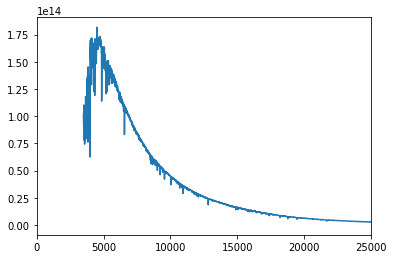

In [11]:
sp = str(data[0]['SP_TYPE'])[2:4] #obtain 2-character spectral type from data table
temp_val = table_temps[np.where(table_types == sp+'V')[0][0]]#convert spectral type to tempterature using lookup table
#lookup table only has V spectral classes, so add V as an approximation

t_index = find_nearest(temps,temp_val)
for file in files:
    if np.int(file.split('-')[0][3:]) == np.int(temps[t_index]):
        spectrum_file = file

wave, SED = np.genfromtxt('./spectra/'+spectrum_file,unpack=True,usecols=(0,1))
wave *= 1e4 # convert to \AA
wave *= 1e-10 # convert to m
SED *= 10/1e-6 #convert to W/m^2/m

#planck = pyasl.planck(temp_val,lam=old_wave) #define planck function from temperature

alphas=[] #initialise array of alphas
order = 3 #order of polynomial to use, determined by analysis in alpha.ipynb
for i in range(0,len(filters)): #loop across filters
    loop_band = np.zeros(len(wave)) #new zeros
    #determine edges of each waveband
    loop_band_min = (centres[i] - widths[i]/2)*1e-10 
    loop_band_max = (centres[i] + widths[i]/2)*1e-10
    #find corresponding indexes
    loop_start_index = (np.abs(wave - loop_band_min)).argmin()
    loop_end_index = (np.abs(wave - loop_band_max)).argmin()

    #set values within indexes to one
    for j in range(loop_start_index, loop_end_index):
        loop_band[j] = 1.0

    loop_trans = SED*loop_band #find transmission in each standard filter
    loop_flux = integ.simps(loop_trans, wave, dx=10e-10) #find total flux in each standard filter
    z_calc = 2.5*math.log10(loop_flux) #find zero point
    new_alpha = zeros[i]/z_calc #find proportionalty between calculated zero and known zero
    alphas.append(new_alpha) #add to array
poly = np.poly1d(np.polyfit(centres,alphas,order)) #fit polynomial to the alpha values

#plt.plot(old_wave*1e10,planck)
plt.plot(wave*1e10, SED)
plt.xlim(0,25000)
plt.show()

Define waveband for target filter:

In [12]:
Fmid = 6200 #desired filter centre
Fwidth = 1240 #desired filter width

old_wave = np.arange(10e-10, 25000e-10,10e-10) #initialise wavelength range

band = np.zeros(len(wave)) #create zeros
#determine edges of waveband
band_min = (Fmid - Fwidth/2)*1e-10
band_max = (Fmid + Fwidth/2)*1e-10
#find corresponding indexes in array
start_index = (np.abs(wave - band_min)).argmin()
end_index = (np.abs(wave - band_max)).argmin()

#set values within indexes to one
for i in range(start_index, end_index):
    band[i] = 1.0
    

Determine flux in waveband from SED and zero point for filter:

In [13]:
alpha = poly(Fmid) #find alpha for given filter centre
print('alpha: '+str(alpha))

trans = SED*band #find transmission in given filter
flux = integ.simps(trans, wave, dx=10e-10) #find total flux
z_calc = 2.5*math.log10(flux) #calculate zero point
zp = alpha*z_calc #use correction to obtain actual zero point

alpha: -1.2109878664412204


Repeat process to find band flux for B filter:

In [14]:
Bmid = 4450 #centre
Bwidth = 940 #width

Bband = np.zeros(len(wave)) #new zeros
#find edges of band
Bband_min = (Bmid - Bwidth/2)*1e-10
Bband_max = (Bmid + Bwidth/2)*1e-10
#find corresponding indexes
Bstart_index = (np.abs(wave - Bband_min)).argmin()
Bend_index = (np.abs(wave - Bband_max)).argmin()

#set values within indexes to one
for i in range(Bstart_index, Bend_index):
    Bband[i] = 1.0
    
Btrans = SED*Bband #find band transmission
Bflux_2 = integ.simps(Btrans, wave, dx=10e-10) #integrate to get flux in band
#Bmag_calc = -2.5*math.log10(Bflux) + B_zp
#plt.plot(wave*1e10,trans,label='V')
#plt.plot(wave*1e10,Btrans,label='B')
#plt.legend()
#plt.xlim(3000,7000)

Evaluate equation: $m_X = m_B + 2.5\log\frac{F_B}{F_X} - \Delta zp$

where: $\Delta zp = zp_B - zp_X$

Then convert to $m_X$ to $F_X$

In [15]:
BfoFf = Bflux_2/flux #calculate ratio of flux in B and flux in filter
Dzp = B_zp - zp #delta zero points
Fmag = Bmag + 2.5*math.log10(BfoFf) - Dzp #calcualte magnitude in filter

scaled_Fflux = 10**((zp - Fmag)/2.5) #convert to flux

telescope_eff = 0.96*0.96*(1-0.005)
rec_flux = scaled_Fflux*telescope_eff

telescope_r = 0.305
telescope_area = np.pi*telescope_r*telescope_r
telescope_obs = 0.47

rec_flux = rec_flux*telescope_area*telescope_obs
rec_flux

1.074031105718324e-14

In [16]:
ccd_poly_coef = np.genfromtxt('./CCD-effs/'+camera_name+'.poly',usecols=(1))
filter_wave, trans = np.genfromtxt('Sloanr\'20s.dat',unpack=True,skip_header=(3))
ccd_poly = np.poly1d(ccd_poly_coef)
ccd_res_curve = ccd_poly(wave)
ccd_res_band = ccd_res_curve[start_index:end_index]
ccd_res = np.mean(ccd_res_band)
ccd_flux = rec_flux*ccd_res
print(ccd_flux)

#plt.plot(filter_wave*1e10,trans)
#plt.plot(filter_wave*1e10,ccd_res_curve)
#plt.ylim(0,1)
#plt.xlim(3600,11000)
#plt.plot(filter_wave*1e10,trans*ccd_res_curve)
#plt.show()

#tot_flux_curve = trans*ccd_res_curve*rec_flux
#total_flux = integ.simps(tot_flux_curve, filter_wave, dx=20e-10)

#det_flux = tot_eff
#total_flux

6.85205867432844e-15


Volume under a 2D Gaussian: $V = 2\pi A\sigma_x\sigma_y$, where $A$ is the amplitude of the Gaussian, and $\sigma_x$ and $\sigma_y$ are based on the seeing, and are hence the same value. Re-arranging gives: $A = \frac V{2\pi\sigma_x\sigma_y}$

In [17]:
total_flux = ccd_flux
gauss_amp = total_flux/(2*np.pi*site_seeing*site_seeing)
def integrand(x, y, A, sigma):
    return A*np.exp(-1/(2*sigma*sigma)*(x*x+y*y))
I = integ.dblquad(integrand,-pixel_width_as/2,pixel_width_as/2,-pixel_width_as/2,pixel_width_as/2, args=(gauss_amp,site_seeing))[0]
I

4.230626711194576e-15

Convert flux on a single pixel back into number of electrons/counts as required, and then calculate maximum time, this cell uses a coefficient from the coeff_finder.ipynb:

In [20]:
coefficient = 0.572 # obtained from coeff_finder.ipynb
gain = 1.4 # e-/counts
actual = I/coefficient # J/s
h = 6.634e-34
c = 3e8
avgE = h*c/(Fmid*1e-10) #average energy of a photon in the band

max_electrons = 110000 # e-

photon_rate = actual/avgE # per s
electron_rate = photon_rate*ccd_res #e-/s
#count_rate = electron_rate/gain #count/s
time = max_electrons/electron_rate # s
time #max time

7.483156457066048